In [ ]:
#%%

#
# 60/40 portfolio on optimized MA cross parameters using RealTest software
#
#

import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import norgatedata
import quantstats        as qs
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

[2024-04-18 08:42:38.906813] INFO: Norgate Data: NorgateData package v1.0.74: Init complete


In [ ]:
#%%

# Preparing data using Norgate

# Stocks
spy_df = norgatedata.price_timeseries(
    "SPY",
    stock_price_adjustment_setting = norgatedata.StockPriceAdjustmentType.TOTALRETURN,
    padding_setting                = norgatedata.PaddingType.NONE,
    start_date                     = "1990-01-01",
    timeseriesformat               = 'pandas-dataframe',
)

# Bonds
agg_df = norgatedata.price_timeseries(
    "AGG",
    stock_price_adjustment_setting = norgatedata.StockPriceAdjustmentType.TOTALRETURN,
    padding_setting                = norgatedata.PaddingType.NONE,
    start_date                     = "1990-01-01",
    timeseriesformat               = 'pandas-dataframe',
)

In [ ]:
#%%

def macross_backtest(df_, ma_fast, ma_slow):
    df = df_.copy()
    df['FillPrice'] = df['Open' ].shift(-1)
    df['Date'     ] = df.index
    df['DateIn'   ] = df['Date' ].shift(-1)
    df['DateOut'  ] = df['Date' ].shift(-1)
    df.fillna(method='ffill', inplace=True)
    df['EntrySetup'] = 0
    df['ExitRule'  ] = 0
    df['MaFast'] = df['Close'].rolling(ma_fast).mean()
    df['MaSlow'] = df['Close'].rolling(ma_slow).mean()
    df.dropna(inplace=True)
    df.loc[((df['MaFast']>df['MaSlow']) & (df['MaFast'].shift(1)<=df['MaSlow'].shift(1))), 'EntrySetup'] = 1
    df.loc[((df['MaFast']<df['MaSlow']) & (df['MaFast'].shift(1)>=df['MaSlow'].shift(1))), 'ExitRule'  ] = 1
    df.loc[df.index[ 0], 'EntrySetup'] = 1
    df.loc[df.index[-1], 'ExitRule'  ] = 1

    # Position tracking
    in_position      = False
    date_in          = None
    entry_fill_price = 0
    date_out         = None
    exit_fill_price  = 0
    position_history = []
    for index, row in df.iterrows():
        # EntrySetup
        if row['EntrySetup'] == 1:
            date_in          = row['DateIn'   ]
            entry_fill_price = row['FillPrice']
        # ExitRuel
        if row['ExitRule'  ] == 1:
            date_out        = row['DateOut'  ]
            exit_fill_price = row['FillPrice']
            pct_change      = (exit_fill_price - entry_fill_price)/entry_fill_price
            bars            = len(df[date_in:date_out])-1
            position_history.append((
                date_in, 
                date_out, 
                entry_fill_price, 
                exit_fill_price, 
                pct_change,
                bars
                ))

    position_df = pd.DataFrame(position_history, columns=['DateIn', 'DateOut', 'PriceIn', 'PriceOut', 'Return', 'Bars'])
    position_df = position_df.set_index(pd.DatetimeIndex(position_df['DateIn']))

    df['Return'] = df['Close'].pct_change()

    df['StratReturn'] = 0.0
    for index, row in position_df.iterrows():
        sub_df = df[row['DateIn']:row['DateOut']]["Return"]
        df.loc[sub_df.index, 'StratReturn'] = sub_df

    return df['StratReturn']

<Axes: xlabel='Date'>

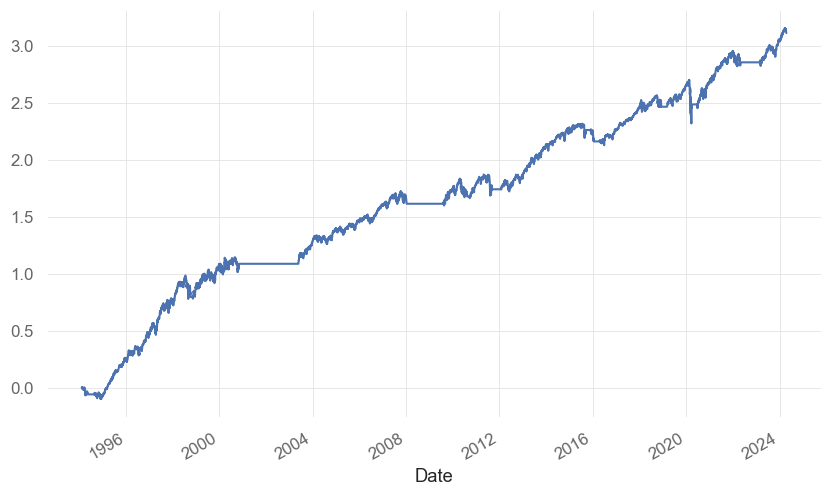

In [ ]:
#%%

spy_df['StratRet'] = macross_backtest(spy_df, ma_fast=40, ma_slow=260)
spy_df['StratRet'].cumsum().plot()

<Axes: xlabel='Date'>

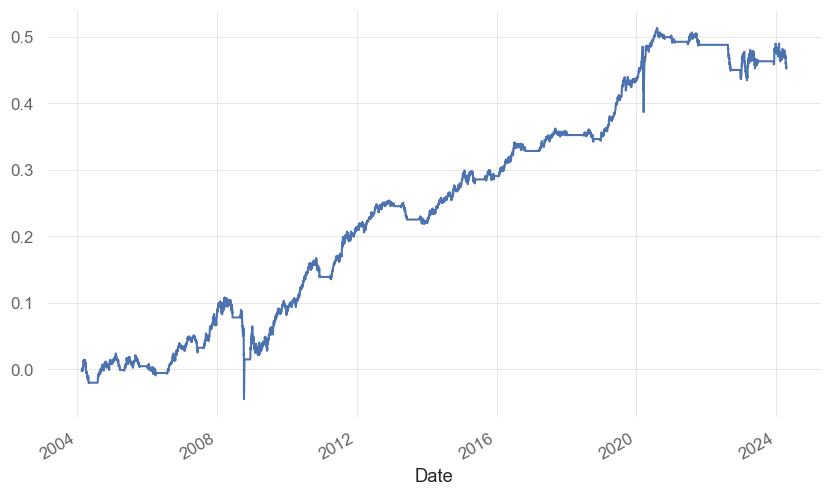

In [ ]:
#%%

agg_df['StratRet'] = macross_backtest(agg_df, ma_fast=30, ma_slow=100)
agg_df['StratRet'].cumsum().plot()

In [ ]:
#%%

qs.stats.sharpe(spy_df['StratRet']), qs.stats.sharpe(agg_df['StratRet'])

(0.7313263245130734, 0.5274952006665922)

<Axes: xlabel='Date'>

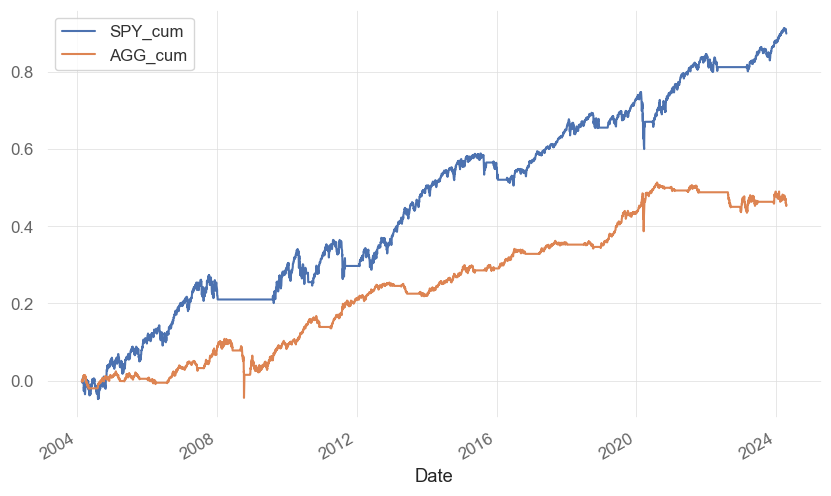

In [ ]:
#%%

df = pd.DataFrame(index=spy_df.index)
df['SPY_ret'] = spy_df['StratRet']
df['AGG_ret'] = agg_df['StratRet']
df['SPY_cum'] = df['SPY_ret'].cumsum()
df['AGG_cum'] = df['AGG_ret'].cumsum()

df.dropna(inplace=True)

df['SPY_ret'] = df['SPY_cum'].pct_change()
df['SPY_cum'] = df['SPY_ret'].cumsum()

df[['SPY_cum', 'AGG_cum']].plot()

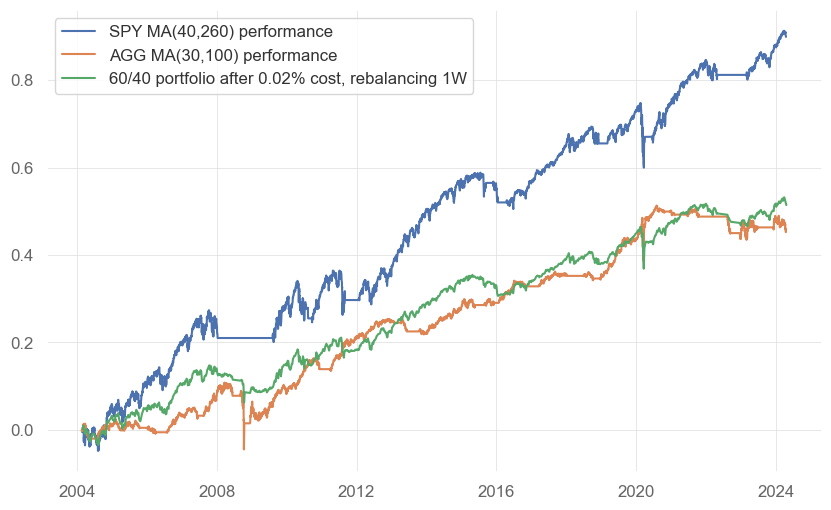

In [ ]:
#%%

# 2 BPS for trading cost proxy using Interactive Brokers fee model, very optimistic
rebalancing_cost        = 0.02/100.0
rebalancing_cost_log    = np.log(1-rebalancing_cost)

previous_rebalance_date = None
rebalance_frequency     = '1W' # rebalancing frequency
stock_weight            = 0.6
bond_weight             = 0.4
portfolio_dates         = []
portfolio_returns       = []

for date, group in df.groupby(pd.Grouper(freq=rebalance_frequency)):
    group_df = group.copy()
    group_df['SPY_freq_cum'] = group_df['SPY_ret'].cumsum()
    group_df['AGG_freq_cum'] = group_df['AGG_ret'].cumsum()
    return_at_rebalance = stock_weight * group_df.iloc[-1]['SPY_freq_cum'] + bond_weight * group_df.iloc[-1]['AGG_freq_cum']
    portfolio_dates.append(date)
    portfolio_returns.append(return_at_rebalance)

portfolio_df = pd.DataFrame(index=portfolio_dates)
portfolio_df.index = pd.to_datetime(portfolio_df.index)
portfolio_df['ret'             ] = portfolio_returns
portfolio_df['log_ret'         ] = (1+portfolio_df['ret']).apply(np.log)
portfolio_df['adjusted_log_ret'] = portfolio_df['log_ret'] + rebalancing_cost_log
portfolio_df['cum'             ] = portfolio_df['log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_cum'    ] = portfolio_df['adjusted_log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_ret'    ] = portfolio_df['adjusted_cum'].pct_change()


plt.plot(df['SPY_cum'])
plt.plot(df['AGG_cum'])
plt.plot(portfolio_df['adjusted_ret'].cumsum())
plt.legend(['SPY MA(40,260) performance', 'AGG MA(30,100) performance', f"60/40 portfolio after {round(rebalancing_cost*100.0, 2)}% cost, rebalancing {rebalance_frequency}"])
plt.show()

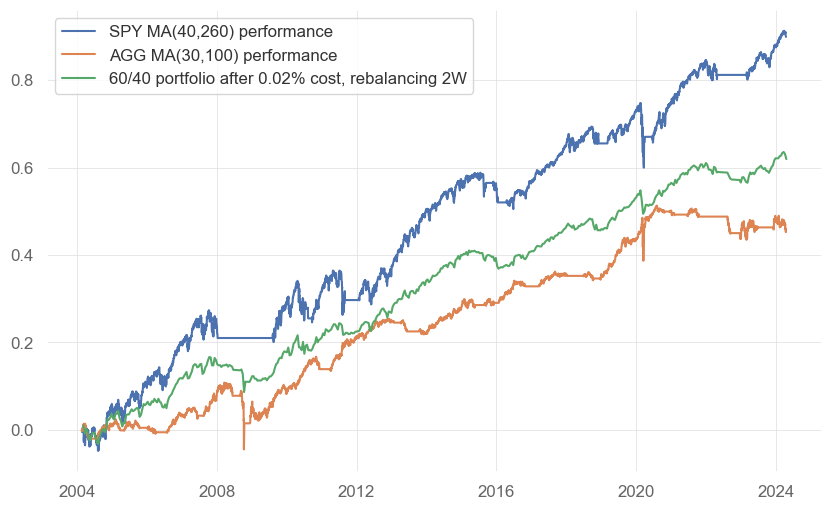

In [ ]:
#%%

# 2 BPS for trading cost proxy using Interactive Brokers fee model, very optimistic
rebalancing_cost        = 0.02/100.0
rebalancing_cost_log    = np.log(1-rebalancing_cost)

previous_rebalance_date = None
rebalance_frequency     = '2W' # rebalancing frequency
stock_weight            = 0.6
bond_weight             = 0.4
portfolio_dates         = []
portfolio_returns       = []

for date, group in df.groupby(pd.Grouper(freq=rebalance_frequency)):
    group_df = group.copy()
    group_df['SPY_freq_cum'] = group_df['SPY_ret'].cumsum()
    group_df['AGG_freq_cum'] = group_df['AGG_ret'].cumsum()
    return_at_rebalance = stock_weight * group_df.iloc[-1]['SPY_freq_cum'] + bond_weight * group_df.iloc[-1]['AGG_freq_cum']
    portfolio_dates.append(date)
    portfolio_returns.append(return_at_rebalance)

portfolio_df = pd.DataFrame(index=portfolio_dates)
portfolio_df.index = pd.to_datetime(portfolio_df.index)
portfolio_df['ret'             ] = portfolio_returns
portfolio_df['log_ret'         ] = (1+portfolio_df['ret']).apply(np.log)
portfolio_df['adjusted_log_ret'] = portfolio_df['log_ret'] + rebalancing_cost_log
portfolio_df['cum'             ] = portfolio_df['log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_cum'    ] = portfolio_df['adjusted_log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_ret'    ] = portfolio_df['adjusted_cum'].pct_change()


plt.plot(df['SPY_cum'])
plt.plot(df['AGG_cum'])
plt.plot(portfolio_df['adjusted_ret'].cumsum())
plt.legend(['SPY MA(40,260) performance', 'AGG MA(30,100) performance', f"60/40 portfolio after {round(rebalancing_cost*100.0, 2)}% cost, rebalancing {rebalance_frequency}"])
plt.show()

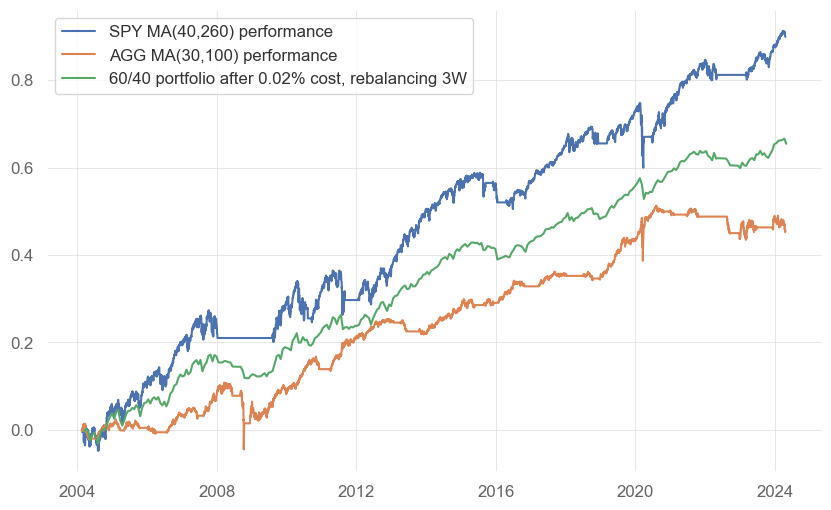

In [ ]:
#%%

# 2 BPS for trading cost proxy using Interactive Brokers fee model, very optimistic
rebalancing_cost        = 0.02/100.0
rebalancing_cost_log    = np.log(1-rebalancing_cost)

previous_rebalance_date = None
rebalance_frequency     = '3W' # rebalancing frequency
stock_weight            = 0.6
bond_weight             = 0.4
portfolio_dates         = []
portfolio_returns       = []

for date, group in df.groupby(pd.Grouper(freq=rebalance_frequency)):
    group_df = group.copy()
    group_df['SPY_freq_cum'] = group_df['SPY_ret'].cumsum()
    group_df['AGG_freq_cum'] = group_df['AGG_ret'].cumsum()
    return_at_rebalance = stock_weight * group_df.iloc[-1]['SPY_freq_cum'] + bond_weight * group_df.iloc[-1]['AGG_freq_cum']
    portfolio_dates.append(date)
    portfolio_returns.append(return_at_rebalance)

portfolio_df = pd.DataFrame(index=portfolio_dates)
portfolio_df.index = pd.to_datetime(portfolio_df.index)
portfolio_df['ret'             ] = portfolio_returns
portfolio_df['log_ret'         ] = (1+portfolio_df['ret']).apply(np.log)
portfolio_df['adjusted_log_ret'] = portfolio_df['log_ret'] + rebalancing_cost_log
portfolio_df['cum'             ] = portfolio_df['log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_cum'    ] = portfolio_df['adjusted_log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_ret'    ] = portfolio_df['adjusted_cum'].pct_change()


plt.plot(df['SPY_cum'])
plt.plot(df['AGG_cum'])
plt.plot(portfolio_df['adjusted_ret'].cumsum())
plt.legend(['SPY MA(40,260) performance', 'AGG MA(30,100) performance', f"60/40 portfolio after {round(rebalancing_cost*100.0, 2)}% cost, rebalancing {rebalance_frequency}"])
plt.show()

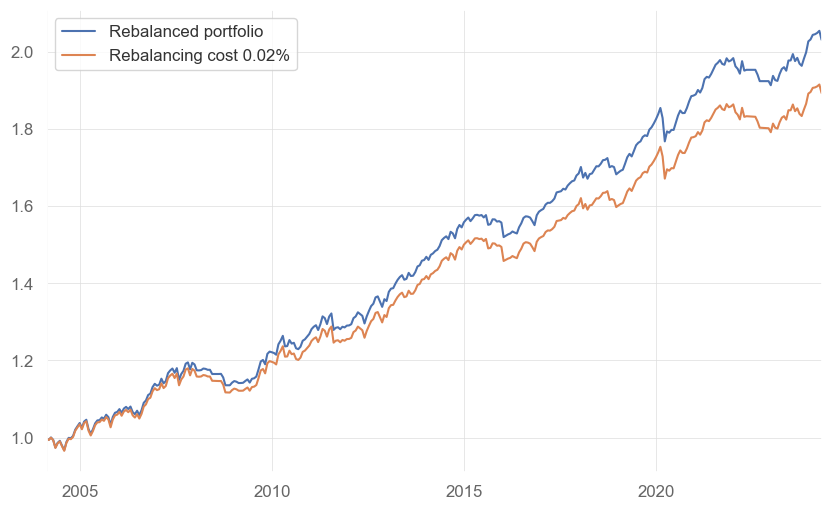

In [ ]:
#%%

portfolio_df[['cum', 'adjusted_cum']].plot()
plt.legend(['Rebalanced portfolio', f"Rebalancing cost {round(rebalancing_cost*100,2)}%"])

                           Strategy
-------------------------  ----------
Start Period               2004-03-14
End Period                 2024-04-28
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          89.92%
CAGR﹪                     2.22%

Sharpe                     3.5
Prob. Sharpe Ratio         99.99%
Smart Sharpe               3.33
Sortino                    5.25
Smart Sortino              4.98
Sortino/√2                 3.71
Smart Sortino/√2           3.52
Omega                      1.79

Max Drawdown               -5.33%
Longest DD Days            715
Volatility (ann.)          13.41%
Calmar                     0.42
Skew                       -0.76
Kurtosis                   1.74

Expected Daily %           0.18%
Expected Monthly %         0.27%
Expected Yearly %          3.1%
Kelly Criterion            28.37%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.2%
Expected Shortfall (cVaR)  -1.2%

Max Consecutive Wins       8
M

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-11-18,2008-11-30,2009-11-01,715,-5.327715,-5.308777
2,2020-03-08,2020-03-29,2020-10-25,232,-4.707878,-3.534584
3,2021-11-28,2023-01-01,2023-11-12,715,-3.909342,-3.404565
4,2015-05-31,2016-01-17,2016-12-18,568,-3.892531,-3.697274
5,2005-03-27,2005-04-17,2005-07-10,106,-3.529146,-2.419697


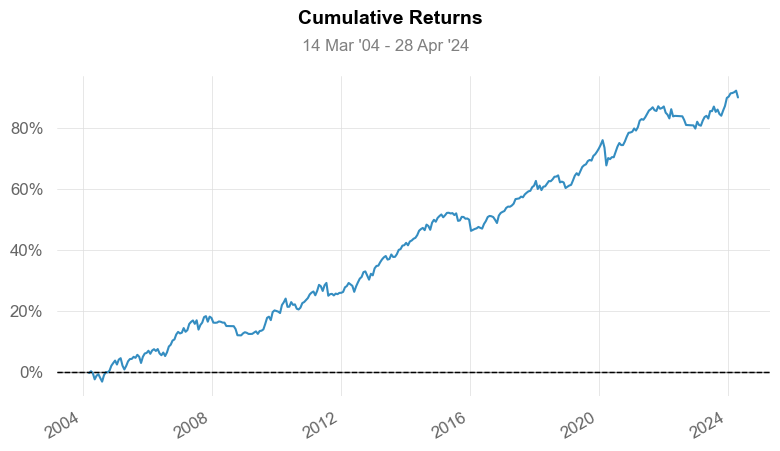

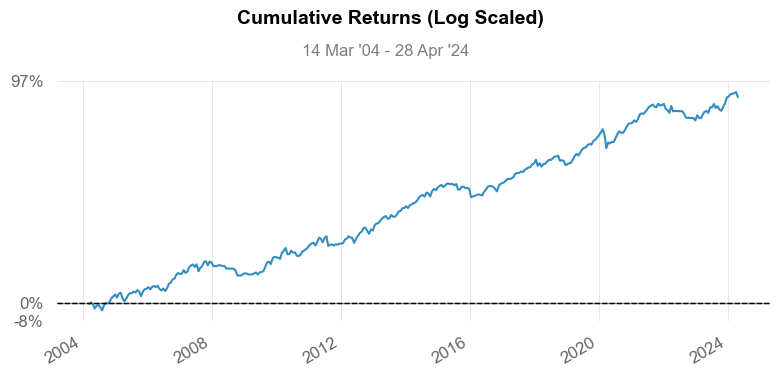

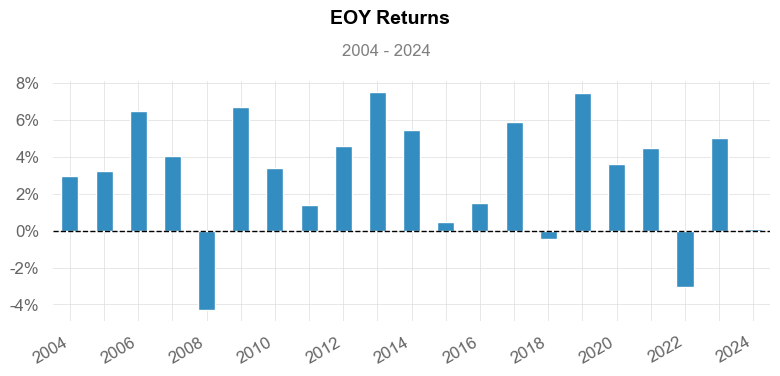

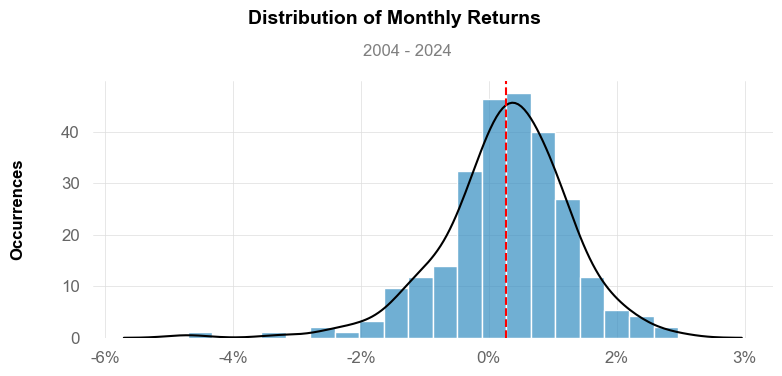

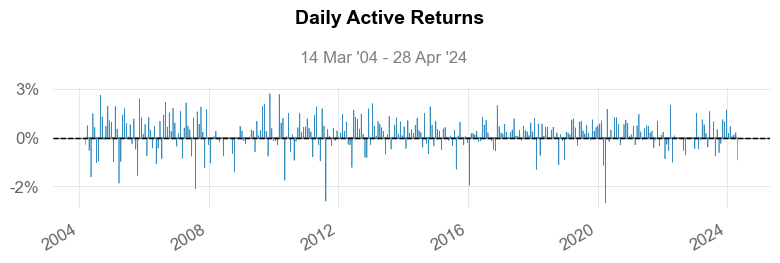

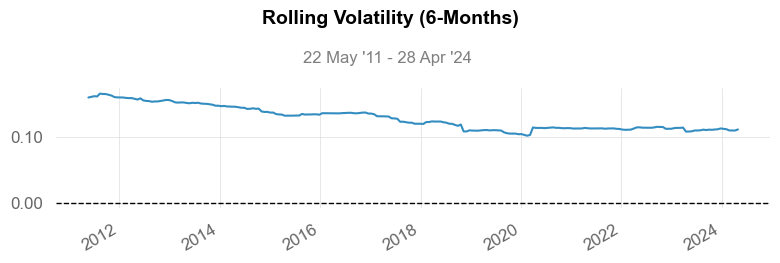

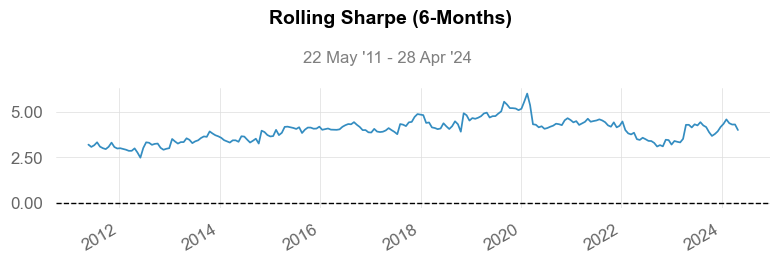

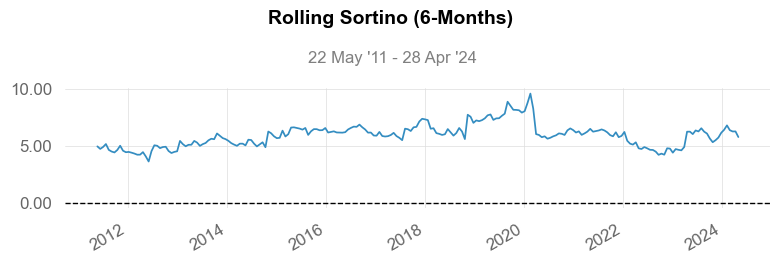

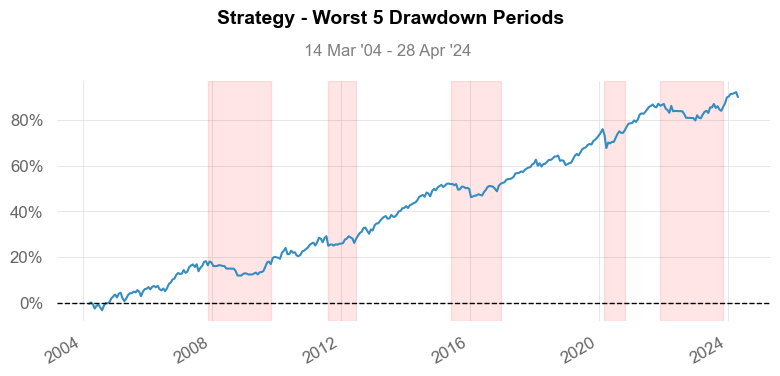

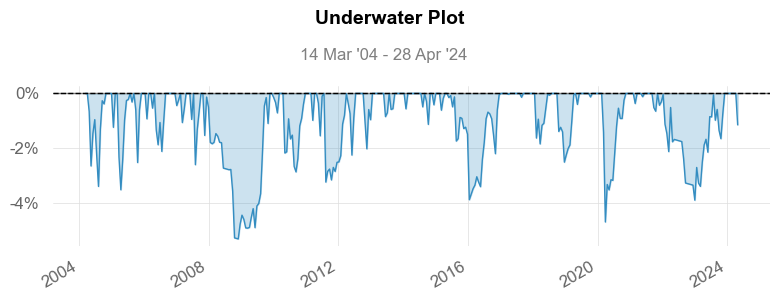

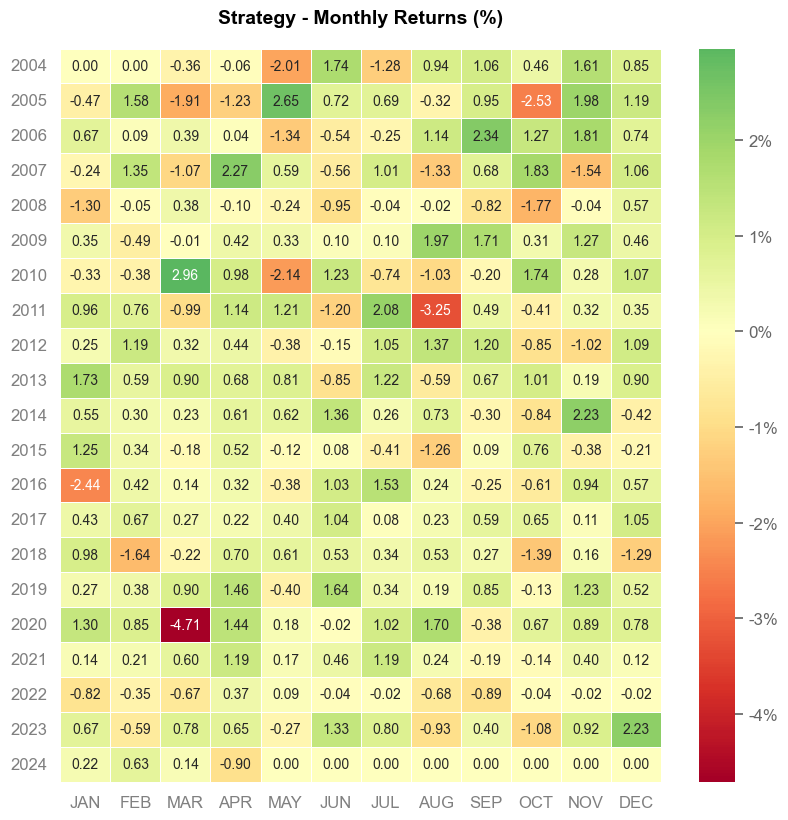

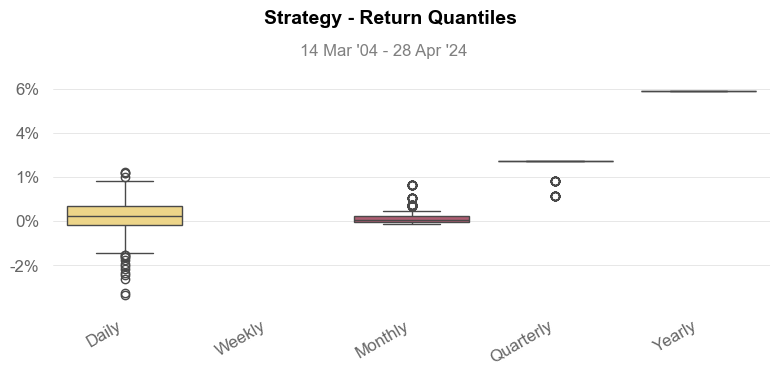

In [ ]:
#%%

qs.reports.full(portfolio_df['adjusted_ret'])